## 02 Forecasting

### Overview

In [1]:
import numpy as np
import pandas as pd
import ibis
import matplotlib.pyplot as plt
import methods.prep as prep
import methods.vis as vis
import importlib

In [ ]:
importlib.reload(vis)
importlib.reload(prep)

### Load Data

In [2]:
con = ibis.connect("duckdb://")

In [3]:
dev_data = ibis.read_csv('data_forecasting/dev_data.csv')

In [ ]:
import skforecast
import pmdarima

### Linear Plots & Stationarity Analysis

For forecasting, features should be stationary, meaning that no significant trends or seasonal patterns should be present in the data.  The mean and variance should be consistent throughout the time period.

No features are stationary without differencing.  The trends are enormous, and while it's difficult to see, some degree of seasonality is almost certainly present.  Many of these look pretty good at first differencing, but some definitely need to be differenced at least one more time.

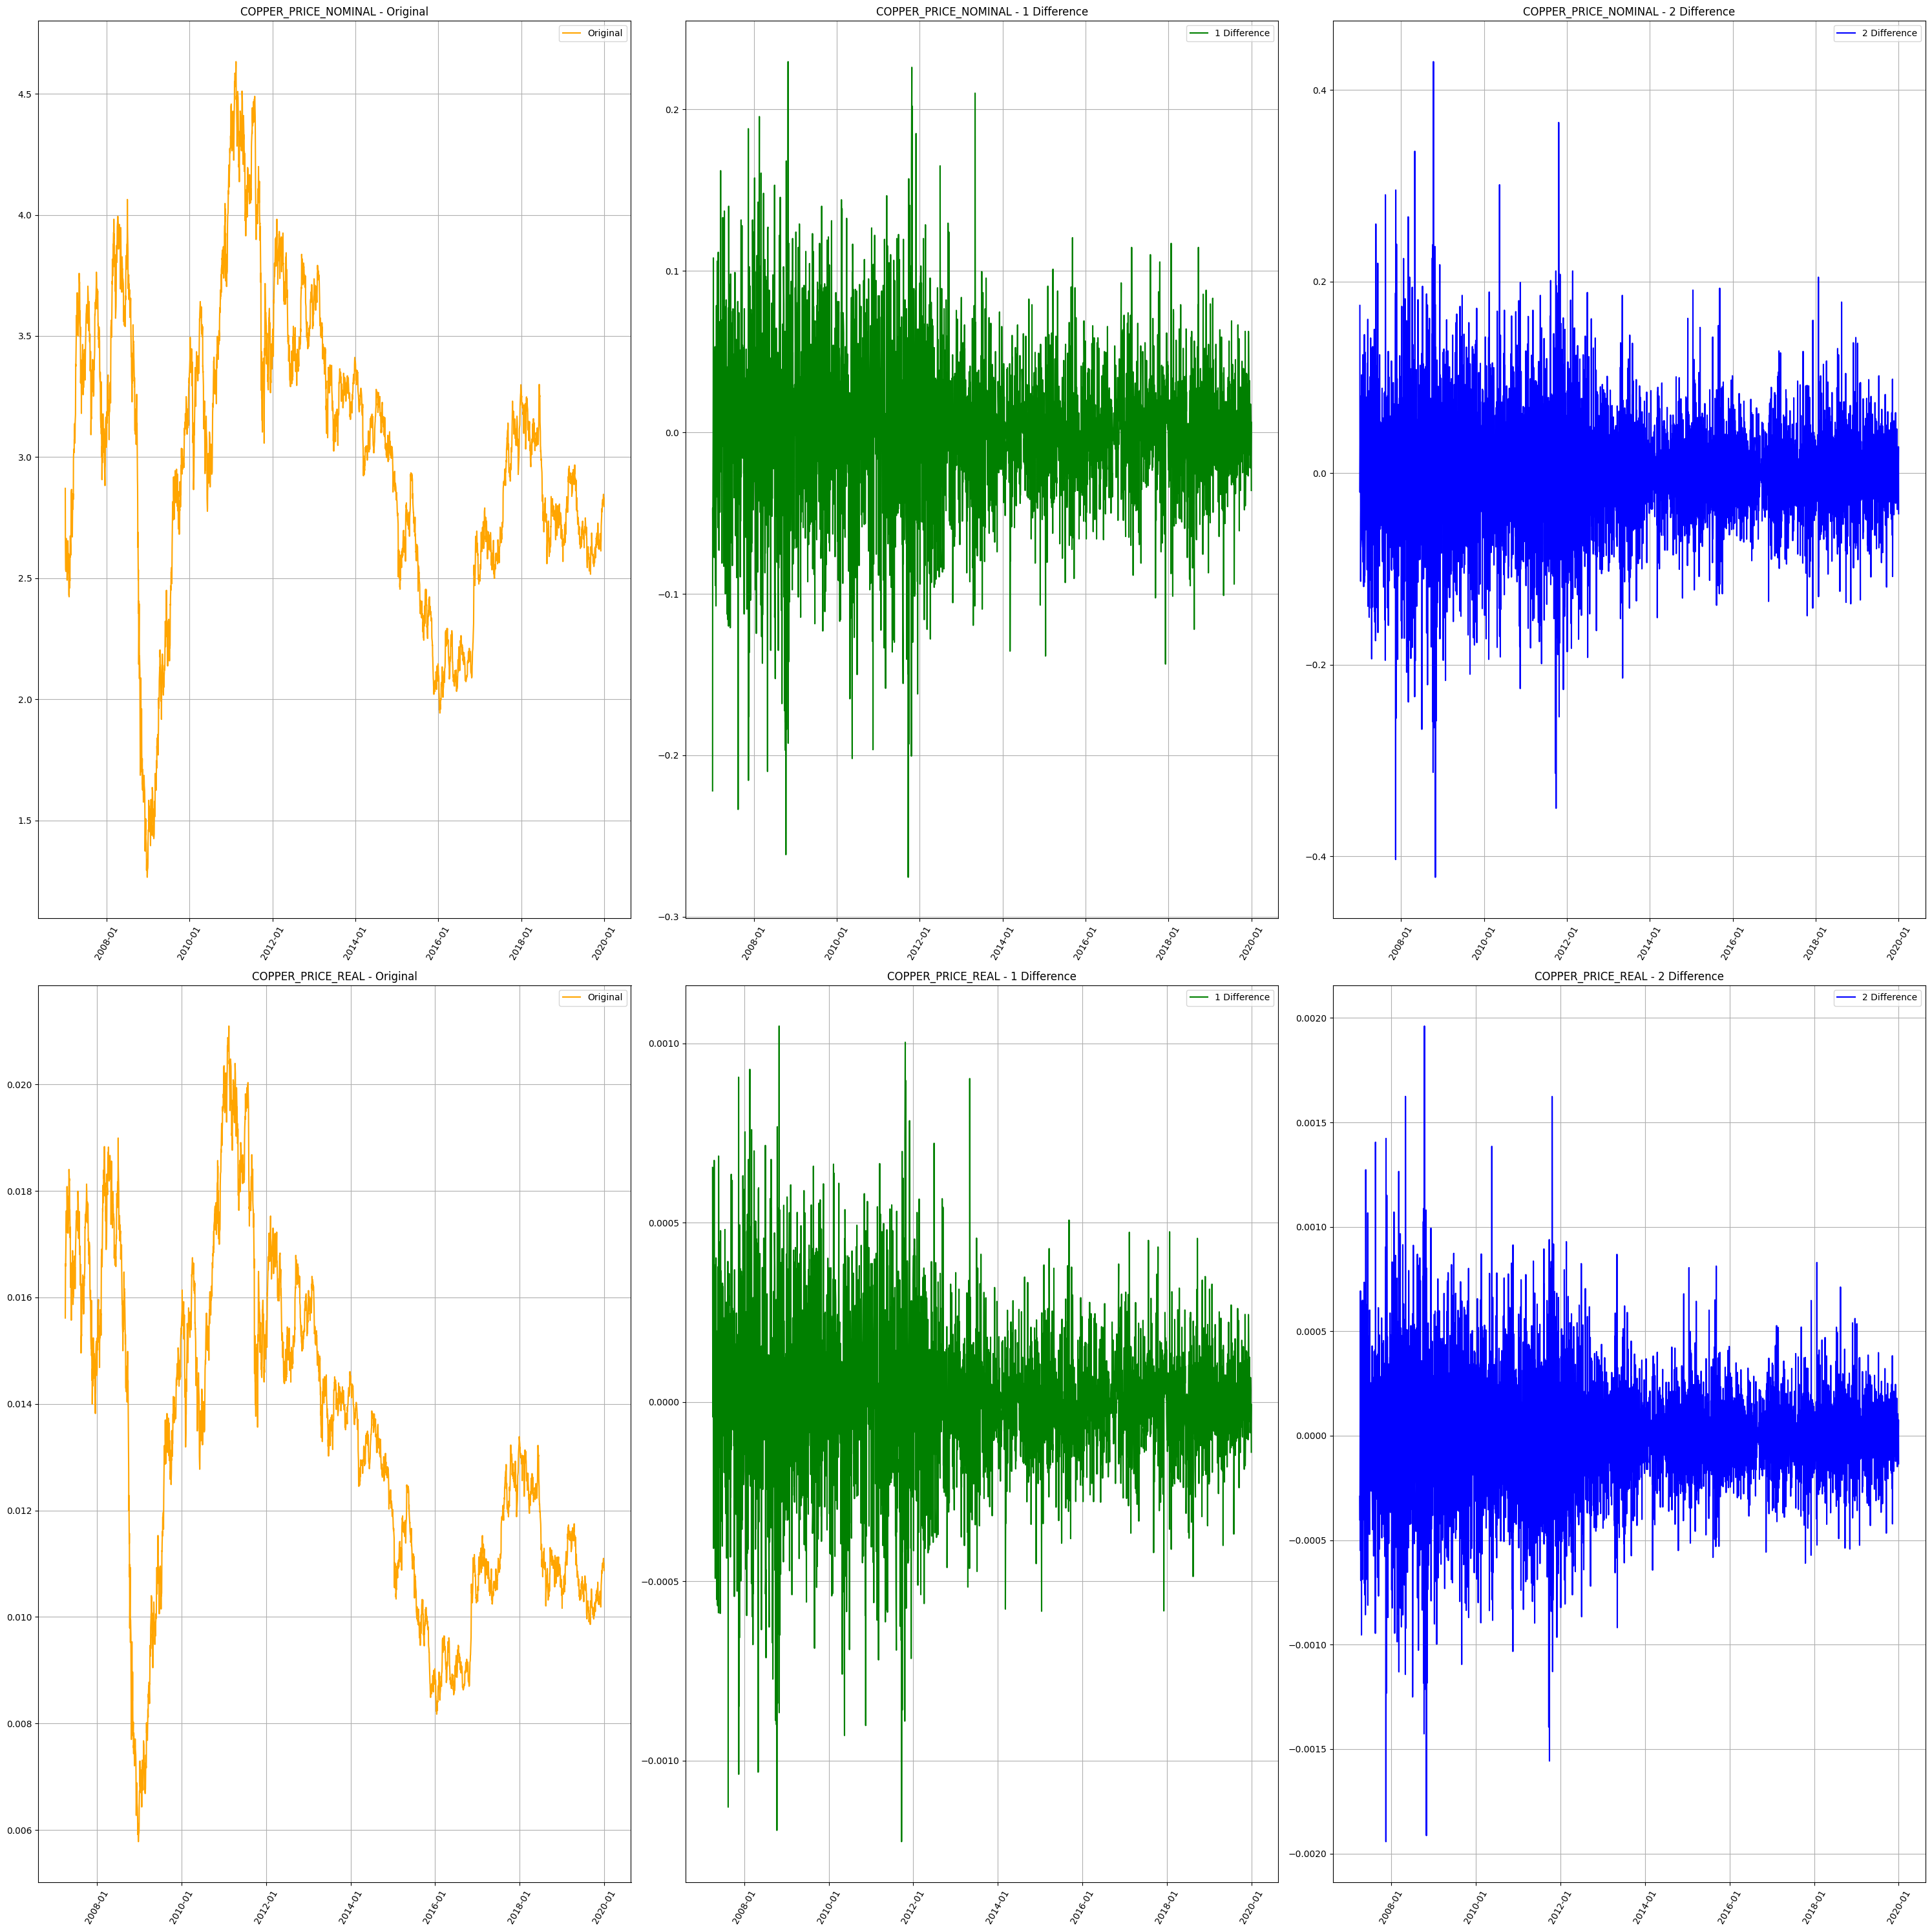

In [7]:
column_list = [
    'DATE',
    'COPPER_PRICE_NOMINAL',
    'COPPER_PRICE_REAL'
]
df = dev_data.select(column_list).to_pandas()
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.sort_values('DATE')
fig, axes = vis.plot_time_series_diffs(
    df, 
    num_diffs = 2)

### Annual Decomposition

In [55]:
importlib.reload(prep)

annual_decomp_features = [
    'COPPER_PRICE_NOMINAL'
]

annual_decomp = prep.annual_decomposition(
    dev_data,
    decomp_features=annual_decomp_features
)

annual_decomp.to_pandas().head()



,DATE,2007_COPPER_PRICE_NOMINAL,2008_COPPER_PRICE_NOMINAL,2009_COPPER_PRICE_NOMINAL,2010_COPPER_PRICE_NOMINAL,2011_COPPER_PRICE_NOMINAL,2012_COPPER_PRICE_NOMINAL,2013_COPPER_PRICE_NOMINAL,2014_COPPER_PRICE_NOMINAL,2015_COPPER_PRICE_NOMINAL,2016_COPPER_PRICE_NOMINAL,2017_COPPER_PRICE_NOMINAL,2018_COPPER_PRICE_NOMINAL,2019_COPPER_PRICE_NOMINAL
0,2000-01-09,2.5560,3.2835,1.5595,NaN,NaN,3.4160,3.6705,3.2990,2.7545,NaN,2.5385,3.2040,2.6570
1,2000-01-23,2.5795,3.0720,1.4720,NaN,NaN,3.7985,3.6845,3.2855,2.5015,NaN,2.6475,3.0980,2.6585
2,2000-01-30,2.5705,3.2360,1.4755,NaN,NaN,3.8335,3.7580,3.2290,2.4955,NaN,2.6610,3.1890,2.7675
3,2000-02-06,2.5020,3.3190,1.6360,NaN,NaN,3.8715,3.7485,3.2280,2.5880,NaN,2.6580,3.1890,2.8365
4,2000-02-13,2.5950,3.5370,1.5475,NaN,NaN,3.8440,3.7515,3.2500,2.6110,NaN,2.7900,3.1625,2.7730


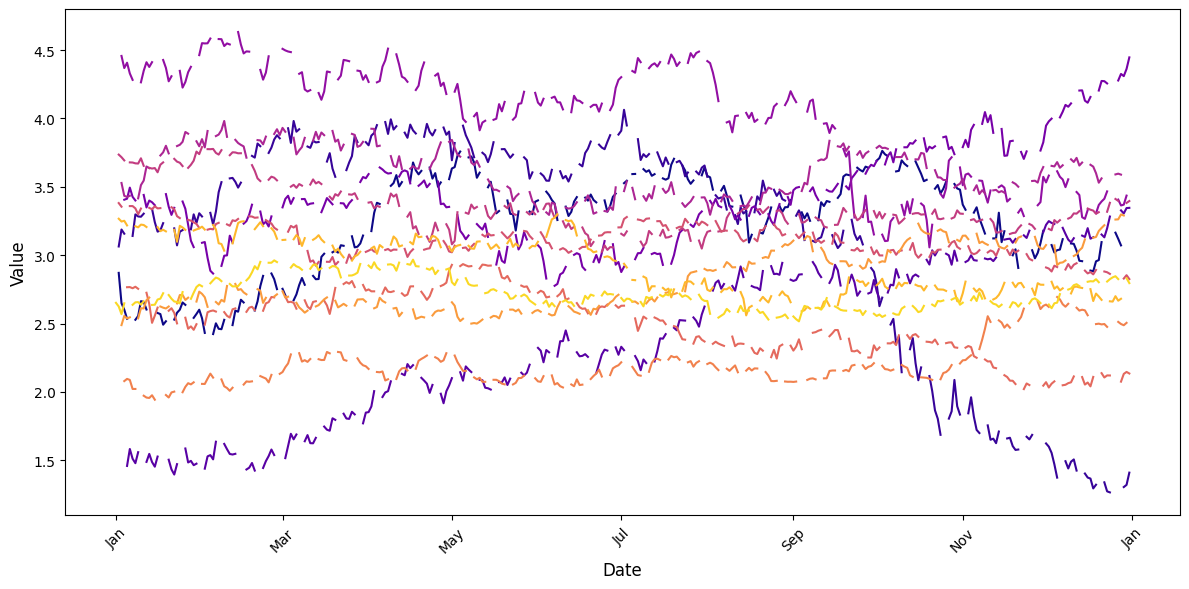

In [65]:
importlib.reload(vis)
vis.plot_decomp(annual_decomp)

##### Common Stationarity Tests

In [ ]:
# TODO add functional stationarity tests & interpretation
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
adfuller(df['copper_PRICE'])

In [ ]:
stationarity_tests = {
    'adfuller' :  adfuller(df['copper_Price']),
    'kpss' : kpss(df['copper_Price']) 
}

### Baseline Models

Key tools:
- [skforecast](https://skforecast.org/)
- [pmdarima](https://github.com/alkaline-ml/pmdarima)
- [sklearn scaling]()

In [ ]:
from skforecast.sarimax import Sarimax
from sklearn.preprocessing import StandardScaler

Pure ARIMA model

In [ ]:
df = dev_data.to_pandas()
df['DATE'] = pd.to_datetime(df['DATE'])
pdq = (1,1,1) # p autoregression lags, d differences, q moving average
model = Sarimax(order = pdq)
model.fit(
    y = df['COPPER_PRICE'])
model.summary()

Simple ARIMAX model

In [ ]:
df = dev_data.to_pandas()
exog_cols = [col for col in df.columns if '_OPEN' in col]
exog = df[exog_cols]
pdq = (1,1,1) # p autoregression lags, d differences, q moving average
model = Sarimax(order = pdq)
model.fit(
    y = df['COPPER_PRICE'],
    exog = exog)
model.summary()

In [ ]:
df = dev_data.to_pandas()
(df['COPPER_OPEN'] - df['COPPER_OPEN'].mean())/df['COPPER_OPEN'].std()

In [ ]:
df = dev_data.to_pandas()
exog_cols = [col for col in df.columns if '_OPEN' in col]
exog = df[exog_cols]
exog = exog.drop(['NATGAS_OPEN','GOLD_OPEN','CORN_OPEN'], axis='columns')
exog = (exog - exog.mean())/exog.std()

target = df['COPPER_PRICE']
target = (target - target.mean())/target.std()

pdq = (1,1,1) # p autoregression lags, d differences, q moving average
model = Sarimax(order = pdq)
model.fit(
    y = target,
    exog = exog)
model.summary()

### Feature Engineering